[View in Colaboratory](https://colab.research.google.com/github/aksh98/Advanced_Biometrics_Assignments/blob/master/BiometricsProject.ipynb)

In [2]:
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Activation,Dropout,Bidirectional,Flatten,Dense,Conv2D,MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import train_test_split

import os
import numpy as np
import math

Using TensorFlow backend.


In [15]:
#Args - input_tensor=
model = VGG16()

print(model.summary())
# plot_model(model, to_file='vgg.png')



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
## ================================================================
## ========= INPUTS ===============================================

def video_to_frames(input_loc, output_loc):
    """    Args:
        input_loc: Input video file.
        output_loc: Output directory to save the frames.
    Returns:
        None
    """
    import time
    import cv2
    import os
    try:
        os.mkdir(output_loc)
    except OSError:
        pass
 
    time_start = time.time()
    
    cap = cv2.VideoCapture(input_loc)
    
    video_length = int(cap.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT)) - 1
    print ("Number of frames: ", video_length)
    count = 0
    print ("Converting video..\n")
    # Start converting the video
    while cap.isOpened():
        # Extract the frame
        ret, frame = cap.read()
        # Write the results back to output location.
        cv2.imwrite(output_loc + "/%#05d.jpg" % (count+1), frame)
        count = count + 1
        # If there are no more frames left
        if (count > (video_length-1)):
            # Log the time again
            time_end = time.time()
            # Release the feed
            cap.release()
            # Print stats
            print ("Done extracting frames.\n%d frames extracted" % count)
            print ("It took %d seconds forconversion." % (time_end-time_start))
            break

## ================================================================





In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpe9wkic6e/pubring.gpg' created
gpg: /tmp/tmpe9wkic6e/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [4]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [7]:
%cd drive
%cd Colab Notebooks

/content/drive
/content/drive/Colab Notebooks


In [6]:
!ls


datalab  drive


In [12]:
# X_train, Y_train, X_valid, Y_valid = load_data()
img_width, img_height = 224,224
width_test,ht_test = 224,224
train_data_dir = 'BiomProject/train'
test_data_dir = 'BiomProject/test'

train_samples = 2717
test_samples = 153

# train - 1537 (0-1536) original samples
#         2717 (0-2716)total samples 250*250 - 1180

# test - 0-86 = 87 swapped 
#        87-152 = original 158*215 97*150

epochs = 50

original_len = 1537  
swapped_len = 1180

swapped_test = 87
original_test = 66 

batch_size = 16

# For Theano
# Switch RGB to BGR order 
# x = x[:, ::-1, :, :]
# # Subtract ImageNet mean pixel 
# x[:, :, :, 0] -= 103.939
# x[:, :, :, 1] -= 116.779
# x[:, :, :, 2] -= 123.68

top_model_weights_path = 'BiomProject/bottleneck_model.h5'
weights_path = 'BiomProject/vgg16_weights.h5'

# model_weights_path = 'fc_model.h5'

def save_bottleneck_features():
    model = VGG16(include_top=False, weights = 'imagenet')
    
# Data Augmentation ------------------------------------------
    train_datagen = ImageDataGenerator(
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        rescale = 1./255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest')
    print("augmentation done1")
    test_datagen = ImageDataGenerator(rescale = 1./255)
#     print("train_Samples",train_samples)
    
# Data Generator --------------------------------------------
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',shuffle=False)

    test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size = (width_test, ht_test),
        batch_size = batch_size, 
        class_mode = None) # yield batches of data, no labels

    train_samples = len(train_generator.filenames)  
    test_samples = len(test_generator.filenames)
    
    print("train_Samples",train_samples)
    print("test_samples",test_samples)
    
    print("data_generated2")
    predict_size_train = int(math.ceil(train_samples / batch_size))
    predict_size_test = int(math.ceil(test_samples / batch_size))
    # if predict_size_test not perfect - give hardcoded input
    bottleneck_features_train = model.predict_generator(train_generator, predict_size_train)
    print("predict_generator1")
    bottleneck_features_test = model.predict_generator(test_generator, predict_size_test)
    print("predict_generator2")
#     np.save(open('bottleneck_features_train.npy','wb'),bottleneck_features_train)
    np.save('bottleneck_features_train',bottleneck_features_train)
    
    np.save('bottleneck_features_test',bottleneck_features_test)
    
#     np.save(open('bottleneck_features_test.npy','wb'),bottleneck_features_test)
    print("bottleneck_features_saved3")
    
save_bottleneck_features()


augmentation done1
Found 2716 images belonging to 2 classes.
Found 152 images belonging to 2 classes.
train_Samples 2716
test_samples 152
data_generated2
predict_generator1
predict_generator2
bottleneck_features_saved3


(2716, 7, 7, 512)
(152, 7, 7, 512)
heylp
Epoch 1/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.3656 - acc: 0.9554
Epoch 2/50
2716/2716 [==============================] - 3s 995us/step - loss: 0.1921 - acc: 0.9794
Epoch 3/50
2716/2716 [==============================] - 3s 986us/step - loss: 0.1216 - acc: 0.9871
Epoch 4/50
2716/2716 [==============================] - 3s 985us/step - loss: 0.0997 - acc: 0.9897
Epoch 5/50
2716/2716 [==============================] - 3s 991us/step - loss: 0.0742 - acc: 0.9923
Epoch 6/50
2224/2716 [=======================>......] - ETA: 0s - loss: 0.0568 - acc: 0.9951

2716/2716 [==============================] - 3s 1ms/step - loss: 0.0526 - acc: 0.9952
Epoch 7/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0436 - acc: 0.9959
Epoch 8/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0332 - acc: 0.9974
Epoch 9/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0271 - acc: 0.9974
Epoch 10/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0425 - acc: 0.9956
Epoch 11/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0326 - acc: 0.9963
Epoch 12/50
 784/2716 [=======>......................] - ETA: 1s - loss: 6.8058e-05 - acc: 1.0000

2716/2716 [==============================] - 3s 1ms/step - loss: 0.0364 - acc: 0.9963
Epoch 13/50
2716/2716 [==============================] - 3s 993us/step - loss: 0.0102 - acc: 0.9985
Epoch 14/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0237 - acc: 0.9967
Epoch 15/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0392 - acc: 0.9952
Epoch 16/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0194 - acc: 0.9982
Epoch 17/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0238 - acc: 0.9967
Epoch 18/50
 384/2716 [===>..........................] - ETA: 2s - loss: 0.0598 - acc: 0.9948

2716/2716 [==============================] - 3s 1ms/step - loss: 0.0202 - acc: 0.9982
Epoch 19/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0213 - acc: 0.9974
Epoch 20/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0244 - acc: 0.9982
Epoch 21/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0301 - acc: 0.9978
Epoch 22/50
2716/2716 [==============================] - 3s 1ms/step - loss: 6.0669e-04 - acc: 0.9993
Epoch 23/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0024 - acc: 0.9993
Epoch 24/50
 304/2716 [==>...........................] - ETA: 2s - loss: 0.0312 - acc: 0.9967

2716/2716 [==============================] - 3s 1ms/step - loss: 0.0038 - acc: 0.9996
Epoch 25/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0098 - acc: 0.9993
Epoch 26/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0140 - acc: 0.9989
Epoch 27/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0081 - acc: 0.9993
Epoch 28/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0179 - acc: 0.9985
Epoch 29/50
2716/2716 [==============================] - 3s 994us/step - loss: 1.0399e-04 - acc: 1.0000
Epoch 30/50
 560/2716 [=====>........................] - ETA: 2s - loss: 0.0100 - acc: 0.9964

2716/2716 [==============================] - 3s 1ms/step - loss: 0.0080 - acc: 0.9989
Epoch 31/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0127 - acc: 0.9989
Epoch 32/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0059 - acc: 0.9996
Epoch 33/50
2716/2716 [==============================] - 3s 988us/step - loss: 0.0215 - acc: 0.9982
Epoch 34/50
2716/2716 [==============================] - 3s 993us/step - loss: 0.0036 - acc: 0.9993
Epoch 35/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0077 - acc: 0.9993
Epoch 36/50
 608/2716 [=====>........................] - ETA: 2s - loss: 1.0765e-07 - acc: 1.0000

2716/2716 [==============================] - 3s 1ms/step - loss: 0.0052 - acc: 0.9993
Epoch 37/50
2716/2716 [==============================] - 3s 1ms/step - loss: 2.1108e-04 - acc: 1.0000
Epoch 38/50
2716/2716 [==============================] - 3s 992us/step - loss: 0.0011 - acc: 0.9996
Epoch 39/50
2716/2716 [==============================] - 3s 986us/step - loss: 0.0060 - acc: 0.9996
Epoch 40/50
2716/2716 [==============================] - 3s 986us/step - loss: 0.0038 - acc: 0.9996
Epoch 41/50
2716/2716 [==============================] - 3s 981us/step - loss: 0.0126 - acc: 0.9985
Epoch 42/50
 624/2716 [=====>........................] - ETA: 2s - loss: 1.0917e-07 - acc: 1.0000

2716/2716 [==============================] - 3s 992us/step - loss: 0.0081 - acc: 0.9993
Epoch 43/50
2716/2716 [==============================] - 3s 982us/step - loss: 0.0079 - acc: 0.9989
Epoch 44/50
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0031 - acc: 0.9996
Epoch 45/50
2716/2716 [==============================] - 3s 985us/step - loss: 0.0059 - acc: 0.9996
Epoch 46/50
2716/2716 [==============================] - 3s 989us/step - loss: 0.0059 - acc: 0.9996
Epoch 47/50
2716/2716 [==============================] - 3s 977us/step - loss: 0.0040 - acc: 0.9993
Epoch 48/50
 768/2716 [=======>......................] - ETA: 1s - loss: 0.0139 - acc: 0.9987

2716/2716 [==============================] - 3s 997us/step - loss: 0.0165 - acc: 0.9974
Epoch 49/50
2716/2716 [==============================] - 3s 992us/step - loss: 0.0059 - acc: 0.9996
Epoch 50/50
152/152 [==============================] - 0s 2ms/step


KeyError: ignored

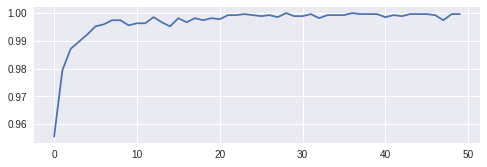

In [26]:
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt

original_len = 1536  
swapped_len = 1180

swapped_test = 86
original_test = 66 

def train_top_model():
    
#     train_data = np.load(open('bottleneck_features_train.npy','wb'))
#     test_data = np.load(open('bottleneck_features_test.npy','wb'))
    train_data = np.load('bottleneck_features_train.npy')
    test_data = np.load('bottleneck_features_test.npy')
    print(train_data.shape)
    print(test_data.shape)
    
    
    ####  CHANGE THISSSSS -------------------
    
    train_labels = np.array([0]*original_len + [1]*swapped_len).astype('float32')
    test_labels = np.array([0]*original_test + [1]*swapped_test).astype('float32')
    
    ##### -----------------------------------
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(BatchNormalization())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation = 'sigmoid'))
    

    model.compile(loss='binary_crossentropy',
          optimizer='rmsprop',
          metrics=['accuracy'])
    
    print("heylp")
    history = model.fit(train_data,train_labels,
             epochs=epochs,batch_size = batch_size)
    
    model.save_weights(top_model_weights_path)
    
    (eval_loss,eval_accuracy) = model.evaluate(test_data,test_labels,batch_size=batch_size,verbose=1)
    
    plt.figure(1)  
    
     # summarize history for accuracy  
    plt.subplot(211)  
    plt.plot(history.history['acc'])  
    plt.plot(history.history['val_acc'])  
    plt.title('model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  

     # summarize history for loss  

    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  
    plt.show()
    
#     np.save('class_indices.npy',generator_top.class_indices)
    
    
#     model.fit_generator(
#         train_generator,
#         steps_per_epoch= train_samples // batch_size,
#         epochs=epochs,
#         validation_data= test_generator,
#         validation_steps= test_samples // batch_size)
   

train_top_model()
# fine_tune()



In [0]:
 def fine_tune():
    model = VGG16(weights='imagenet',include_top=False)
    
    top_model = Sequential()
    top_model.add(Flatten(input_shape = model.output_shape[1:]))
    top_model.add(Dense(256,activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1,activation='sigmoid'))
    
    top_model.load_weights(top_model_weights_path)
    
    model.add(top_model)
    
    for layer in model.layers[:25]:
        layer.trainable = False
    
    model.compile(loss='binary_crossentropy',
                 optimizer=optimizers.SGD(lr=0.0001,momentum=0.9),
                 metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(rescale = 1./255,
          zoom_range=0.2,
          shear_range=0.2,
          horizontal_flip=True,
          height_shift_range = 0.2,
          width_shift_range = 0.2,
          fill_mode='nearest')
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(train_data_dir,
                      target_size = (img_height,img_width),
                      batch_size = batch_size,class_mode='binary')
    
    test_generator = test_datagen.flow_from_directory(test_data_dir,
                      target_size = (ht_test,width_test),
                      batch_size = batch_size,class_mode='binary')
    
    train_samples = len(train_generator.filenames)  
    test_samples = len(test_generator.filenames)
    
    model.fit_generator(
        train_generator,
        samples_per_epoch=train_samples,
        epochs=epochs,
        validation_data=test_generator,
        nb_val_samples=test_samples)
     
fine_tune()